In [1]:
import collections
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
)
from rna_learn.load import load_mrna_model, load_dataset
from rna_learn.model import conv1d_classification_model
from rna_learn.vae import variational_autoencoder, compile_vae

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
alphabet = ['A', 'T', 'G', 'C']
classes = ['psychrophilic', 'mesophilic', 'thermophilic']

In [4]:
run_id = 'run_pv1ea_1'
do_train_vae = False
model_path = os.path.join(os.getcwd(), f'hyperparameters/{run_id}/best_model.h5')
hyperparameters_path = os.path.join(os.getcwd(), f'hyperparameters/{run_id}/best_hyperparameters.json')
test_set_path = os.path.join(os.getcwd(), 'data/dataset_test.csv')
train_set_path = os.path.join(os.getcwd(), 'data/dataset_train.csv')

## Model

In [5]:
with open(hyperparameters_path) as f:
    hyperparameters = json.load(f)
    
hyperparameters

{'iteration': 5,
 'x': {'n_epochs': 20,
  'n_conv_1': 3,
  'n_filters_1': 88,
  'kernel_size_1': 29,
  'n_conv_2': 1,
  'n_filters_2': 54,
  'kernel_size_2': 44},
 'train_loss': 0.5108916163444519,
 'test_loss': 0.5307432413101196,
 'elapsed_seconds': 1727.2782099246979}

In [6]:
model = load_model(model_path)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, None, 4)]         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 88)          10296     
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 88)          224664    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 88)          224664    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, None, 54)          209142    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 54)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 54)                0   

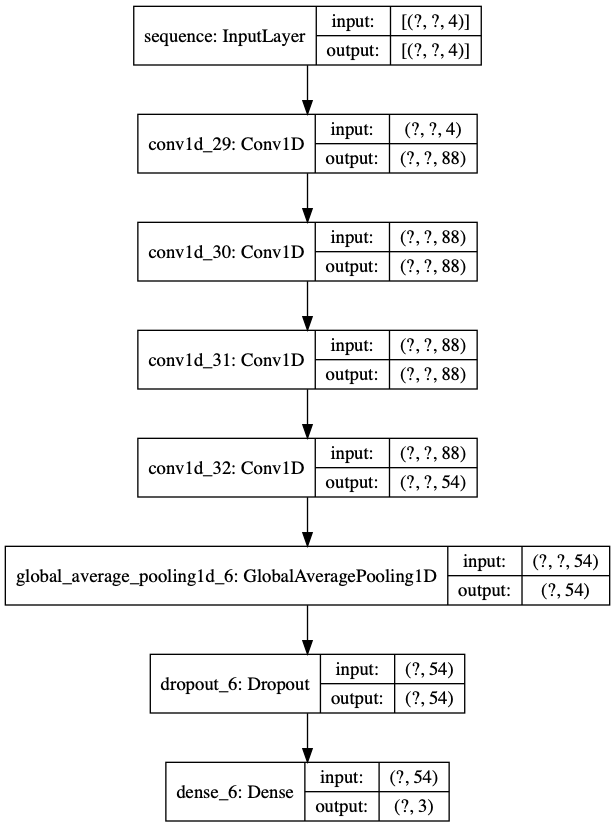

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Dataset

In [42]:
dataset_df = load_dataset(test_set_path, alphabet)
train_dataset_df = load_dataset(train_set_path, alphabet)

# Print first few rows of the test set for reference
dataset_df.head()

,specie_name,seqid,gene_name,start_inclusive,end_exclusive,length,strand,temperature,temperature_range,sequence,gc_content,secondary_structure,paired_nucleotides
0,Micropolyspora internatus,NC_013159.1,rnpB,742238,742645,407,+,45.0,thermophilic,CGAGTTGGCAGGGCGGCCGCGGCCGAGGGCATCGTCTCGACGTCTT...,0.685504,((((((((((((((..((.(((((((((((.(((...))).)))))...,0.707617
1,Listonella anguillarum,NC_015633.1,recA,2753532,2754579,1047,-,20.0,psychrophilic,ATGGACGAAAATAAGCAGAAGGCGCTAGCCGCAGCACTGGGTCAAA...,0.442216,....................(((....)))(((((..(((((((((...,0.617001
2,Comamonas badia,NZ_AXVM01000006.1,rpsR,29593,29878,285,-,28.0,mesophilic,TTGACCATGTTCAGGAAATTCAACAAGAATGGCAAGAACGGCAAGC...,0.568421,(((.((..((((..(..((((.....))))..)..)))))))))((...,0.610526
3,Acetobacter orientalis,NZ_BAMX01000009.1,tsaD,11584,12799,1215,-,30.0,mesophilic,ATGGCGGTCAGCAGCCAGTTTTCAGGCTTACCCGGCACCCCTCACA...,0.596708,.(((.((((...((((........)))).....(((.............,0.627160
4,Alicyclobacillus kakegawensis,NZ_BCRP01000001.1,tsaD,64880,65918,1038,-,50.0,thermophilic,TTGCTCCTGTTGGGCATTGAGACGAGTTGCGACGAGACCGCCGCGG...,0.680154,......((((.(((((.((...((....((((((.(((((.(((((...,0.697495


### Dataset size

In [9]:
print(f'Test set size: {len(dataset_df):,}')
print(f'Train set size: {len(train_dataset_df):,}')
print(f'Total dataset size: {len(dataset_df) + len(train_dataset_df):,}')

Test set size: 3,700
Train set size: 14,804
Total dataset size: 18,504


### Prep data

In [10]:
sequences = dataset_df['sequence'].values
temperature_classes = dataset_df['temperature_range'].values

x_test = sequence_embedding(sequences, alphabet)
y_test = one_hot_encode_classes(temperature_classes, classes)

## Evaluate model

In [11]:
%%time
model.evaluate(x_test, y_test, verbose=0)

CPU times: user 7min 42s, sys: 2.52 s, total: 7min 44s
Wall time: 1min 5s


[0.9559191520794018, 0.5181081]

In [12]:
%%time
y_pred = model(x_test)

labels = [np.argmax(el) for el in y_test]
predictions = [np.argmax(el) for el in y_pred]

CPU times: user 8min 16s, sys: 41.3 s, total: 8min 58s
Wall time: 1min 21s


In [13]:
def plot_confusion_matrix(labels, predictions, classes, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
        
    conf = tf.math.confusion_matrix(labels, predictions).numpy()
    conf_sum = np.sum(conf, axis=1)
    conf_p = conf / conf_sum
    
    df_cm = pd.DataFrame(
        conf_p, 
        index=[f'{c.title()}' for i, c in enumerate(classes)],
        columns=[f'{c.title()}' for i, c in enumerate(classes)],
    )
    ax = sns.heatmap(df_cm, cmap="Greys", annot=True, fmt='.0%', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_xlabel('\nPredictions');
    ax.set_ylabel('Labels');
    ax.set_title('Confusion Matrix')

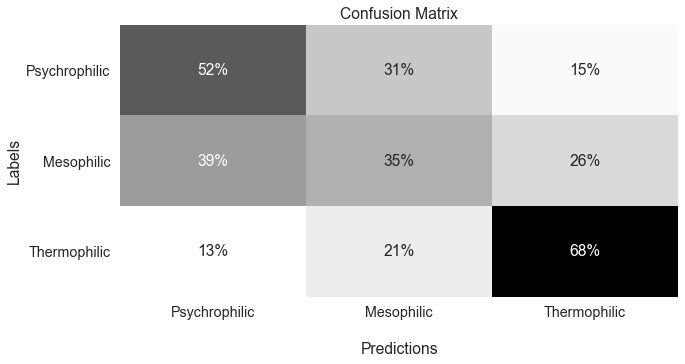

In [14]:
plot_confusion_matrix(labels, predictions, classes)

## Linear regression

In [15]:
def plot_average_data_per_temperature_point(dataset_df, column, fit=True, figsize=(12, 6)):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    x = dataset_df['temperature'].values
    y = dataset_df[column].values
    
    t_min, t_max = int(np.floor(np.min(x))), int(np.ceil(np.max(x)))
    
    x_bins = np.array(list(range(t_min, t_max + 1)))
    
    y_bins_dict = {t: [] for t in x_bins}
    for i, t in enumerate(x):
        x_bin = int(round(t))
        y_v = y[i]
        
        y_bins_dict[x_bin].append(y_v)
        
    y_bins = np.array([
        np.mean(y_bins_dict[x_bin]) 
        for x_bin in x_bins
        if x_bin in y_bins_dict and len(y_bins_dict[x_bin]) > 0
    ])
    x_bins = np.array([x_bin for x_bin in x_bins if x_bin in y_bins_dict and len(y_bins_dict[x_bin]) > 0])
    
    palette = sns.color_palette()
    
    ax.plot(x, y, 'o', color=palette[0], alpha=0.1, label='Actual')
    ax.plot(x_bins, y_bins, 'o', color=palette[1], label='Average')
    
    if fit:
        X_bins = sm.add_constant(x_bins[:,np.newaxis])
        model = sm.OLS(y_bins, X_bins)
        
        results = model.fit()
        
        p_value = results.f_pvalue
        
        a = results.params[1]
        b = results.params[0]
        y_fit = a * x_bins + b
        
        ax.plot(x_bins, y_fit, color=palette[1], linewidth=2, label=f'Fitted (p = {p_value:.2f})')
    
    ax.set_xlabel('Optimal Growth Temperature (°C)')
    ax.set_ylabel(column.replace('_', ' ').title())
    ax.legend()
    
    return f, ax

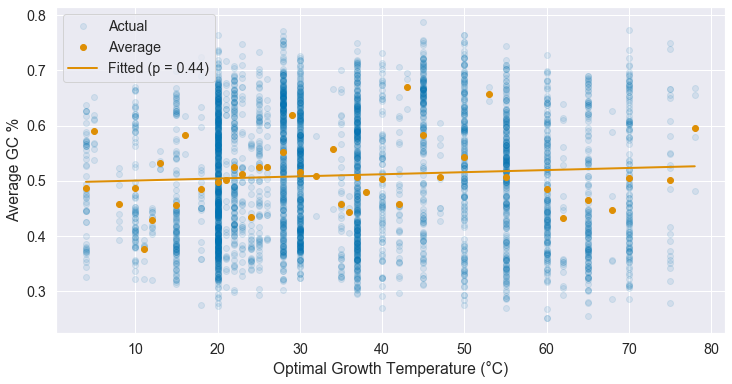

In [16]:
f, ax = plot_average_data_per_temperature_point(dataset_df, 'gc_content')
ax.set_ylabel('Average GC %');

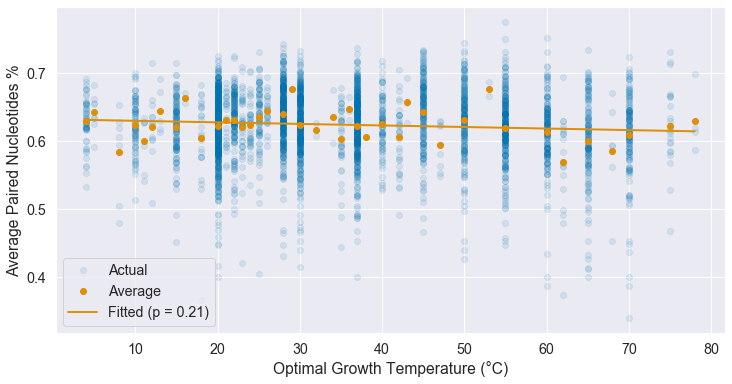

In [17]:
f, ax = plot_average_data_per_temperature_point(dataset_df, 'paired_nucleotides')
ax.set_ylabel('Average Paired Nucleotides %');

## VAE

In [18]:
mid_layer = [l for l in model.layers if l.name.startswith('global_average_pooling1d')][0]

intermediate_layer_model = tf.keras.Model(
    inputs=model.input,
    outputs=mid_layer.output,
)
x_logits = intermediate_layer_model(x_test).numpy()

In [19]:
prior, encoder, decoder, vae = variational_autoencoder(
    n_inputs=x_logits.shape[-1], 
    encoding_size=2, 
    n_hidden=300,
)
compile_vae(vae, learning_rate=1e-4)
vae.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 54)]              0         
_________________________________________________________________
dense (Dense)                (None, 300)               16500     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1505      
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
_________________________________________________________________
model_2 (Model)              (None, 54)                33408     
Total params: 51,413
Trainable params:

In [20]:
%%time
vae_model_path = os.path.join(os.getcwd(), f'hyperparameters/{run_id}/vae.h5')

if do_train_vae:
    vae.fit(
        x_logits, x_logits,
        batch_size=32,
        epochs=1000,
        verbose=1,
    )
    vae.save(vae_model_path)
else:
    vae.load_weights(vae_model_path)
    
print(vae.evaluate(x_logits, x_logits, verbose=0))

-184.47781129579286
CPU times: user 395 ms, sys: 69.3 ms, total: 464 ms
Wall time: 440 ms


In [21]:
encoding_dist = encoder(x_logits)
encoding = encoding_dist.mean().numpy()

In [22]:
def plot_encoding(encoding, labels, classes, figsize=(12, 6), show_only=None):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    palette = sns.color_palette()
    
    seen_labels = set()
    
    for i, code in enumerate(encoding):
        if show_only is not None and labels[i] not in show_only:
            continue
            
        plot_label = None
        if labels[i] not in seen_labels:
            plot_label = classes[labels[i]].title()
            seen_labels.add(labels[i])
            
        ax.plot(code[0], code[1], 'o', color=palette[labels[i]], label=plot_label)
        
    ax.legend()
    
    return f, ax

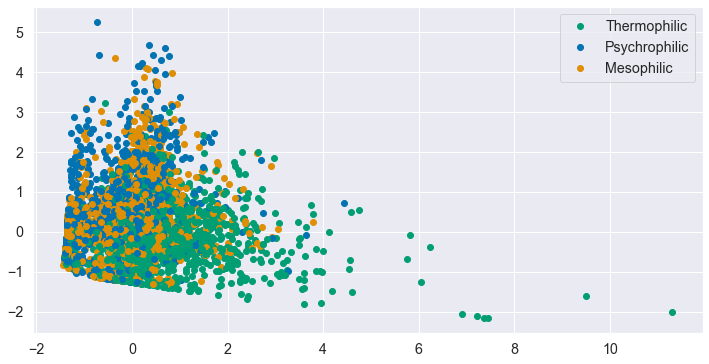

In [23]:
plot_encoding(encoding, labels, classes);

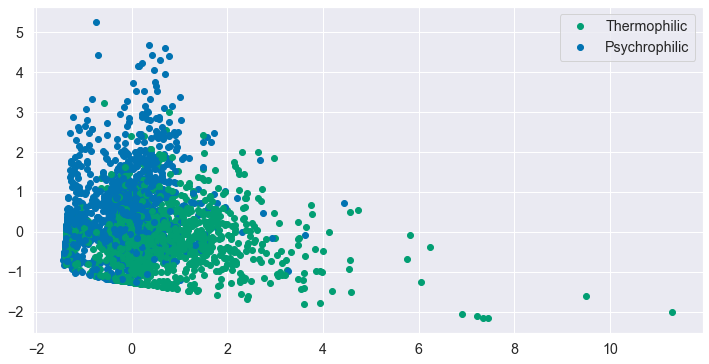

In [24]:
plot_encoding(encoding, labels, classes, show_only=(0, 2));

In [25]:
def plot_encoding_with_alpha_accuracy(encoding, labels, predictions, classes, best_accuracy, figsize=(12, 6)):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    palette = sns.color_palette()
    
    seen_labels = set()
    
    for i, code in enumerate(encoding):
        plot_label = None
        if labels[i] not in seen_labels:
            plot_label = classes[labels[i]].title()
            seen_labels.add(labels[i])
            
        if labels[i] != predictions[i]:
            accuracy = 0.1
        else:
            accuracy = best_accuracy[i]
            
            
        ax.plot(code[0], code[1], 'o', color=palette[labels[i]], label=plot_label, alpha=accuracy)
        
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
    
    return f, ax

In [26]:
best_accuracy = np.array([v[np.argmax(v)] for i, v in enumerate(y_pred.numpy())])

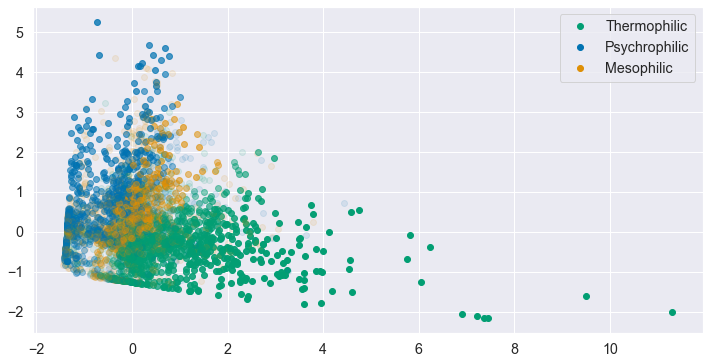

In [27]:
plot_encoding_with_alpha_accuracy(encoding, labels, predictions, classes, best_accuracy);

In [28]:
def plot_correctly_identified_vs_error(encoding, predictions, labels, show_only=None):
    if show_only is None:
        show_only = (0, 1, 2)
    
    n_cols = len(show_only)
    f, axes = plt.subplots(1, n_cols, figsize=(16, 6), sharex=True, sharey=True)
    
    palette = sns.color_palette()
    
    data_ok = collections.defaultdict(list)
    data_neg = collections.defaultdict(list)
    for i, code in enumerate(encoding):
        if show_only is not None and labels[i] not in show_only:
            continue
        
        if labels[i] == predictions[i]:
            data_ok[labels[i]].append(code)
        else:
            data_neg[labels[i]].append(code)
            
    for v in show_only:
        data_ok[v] = np.array(data_ok[v])
        data_neg[v] = np.array(data_neg[v])
        
    for i, v in enumerate(show_only):
        ax = axes[i]
        ax.set_title(classes[v].title())
        ax.scatter(data_ok[v][:, 0], data_ok[v][:, 1], c='green', label='Correct');
        ax.scatter(data_neg[v][:, 0], data_neg[v][:, 1], c='red', label='Error');
        ax.legend()

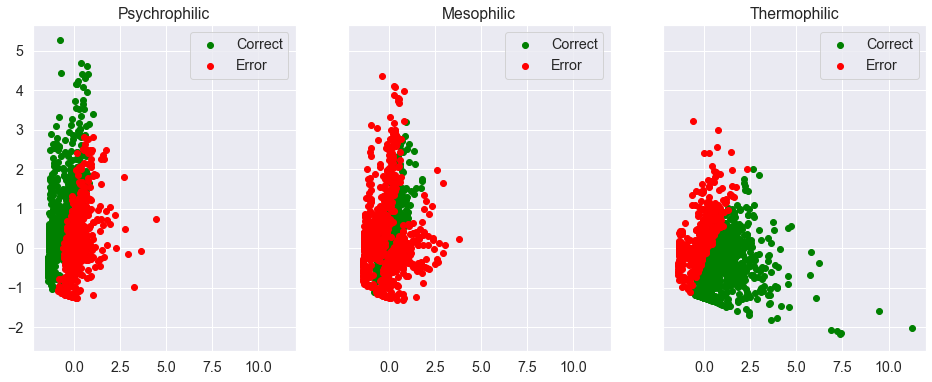

In [29]:
plot_correctly_identified_vs_error(encoding, predictions, labels, show_only=(0, 1, 2));

In [30]:
def plot_encoding_with_colors(encoding, labels, color_vals, figsize=(12, 6), show_only=None):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    palette = sns.color_palette()
    
    x_d, y_d = [], []
    colors = []
    
    for i, code in enumerate(encoding):
        if show_only is not None and labels[i] not in show_only:
            continue
        
        x_d.append(encoding[i,0])
        y_d.append(encoding[i,1])
        colors.append(color_vals[i])
    
    sc = ax.scatter(x_d, y_d, c=colors, cmap='YlOrRd')
    plt.colorbar(sc)
    
    return f, ax

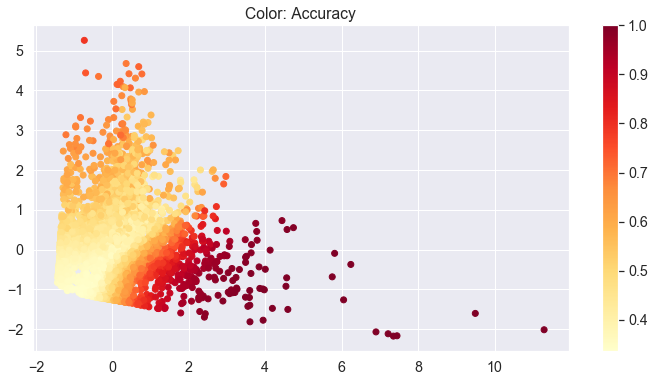

In [31]:
f, ax = plot_encoding_with_colors(encoding, labels, best_accuracy)
ax.set_title('Color: Accuracy');

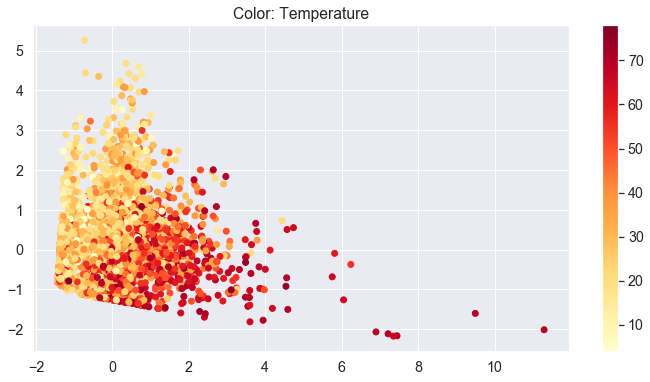

In [32]:
temperatures = dataset_df['temperature'].values
f, ax = plot_encoding_with_colors(encoding, labels, temperatures);
ax.set_title('Color: Temperature');

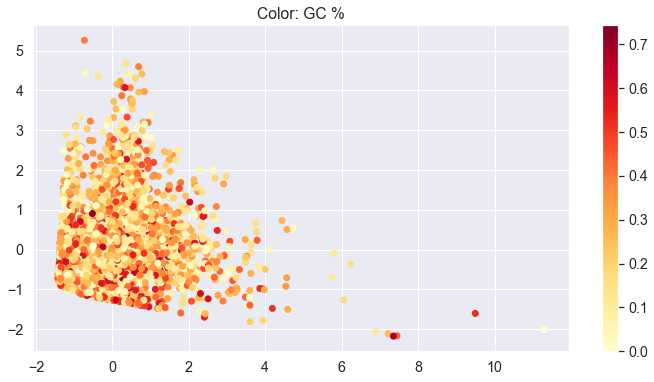

In [33]:
gc = 100 % dataset_df['gc_content'].values
f, ax = plot_encoding_with_colors(encoding, labels, gc);
ax.set_title('Color: GC %');

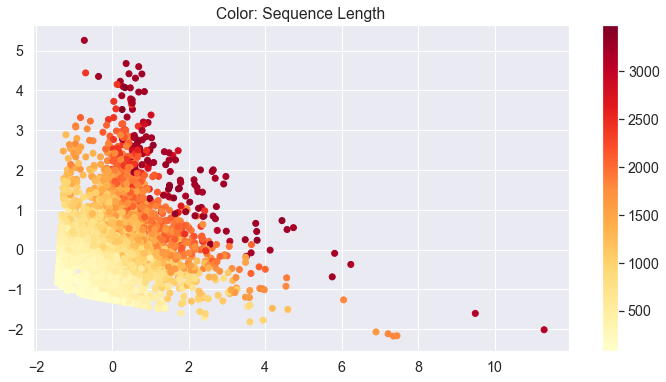

In [34]:
gc = dataset_df['length'].values
f, ax = plot_encoding_with_colors(encoding, labels, gc);
ax.set_title('Color: Sequence Length');

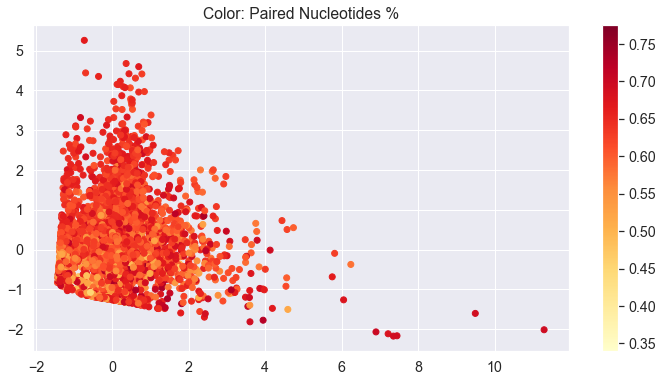

In [35]:
gc = dataset_df['paired_nucleotides'].values
f, ax = plot_encoding_with_colors(encoding, labels, gc);
ax.set_title('Color: Paired Nucleotides %');

In [36]:
def plot_breakdown_per_gene(dataset_df, encoding, labels, predictions, best_accuracy):
    palette = sns.color_palette()
    
    genes = sorted(dataset_df['gene_name'].unique().tolist())
    
    assert len(genes) == 30
    
    f, axes = plt.subplots(10, 3, figsize=(14, 6 * 10))
    axes = axes.flatten()
    
    for i, gene in enumerate(genes):
        ax = axes[i]
        ax.set_title(gene)
        
        gene_dataset = dataset_df[dataset_df['gene_name'] == gene]
        indices = gene_dataset.index
        
        encoding_gene = encoding[indices]
        labels_gene = labels[indices]
        predictions_gene = predictions[indices]
        accuracies = best_accuracy[indices]
        
        seen_labels = set()
    
        for j, code in enumerate(encoding_gene):
            if labels_gene[j] != predictions_gene[j]:
                accuracy = 0.1
            else:
                accuracy = accuracies[j]
            
            ax.plot(code[0], code[1], 'o', color=palette[labels_gene[j]], alpha=accuracy)
            
            ax.set_xlim(-2, 12)
            ax.set_ylim(-2.5, 5.5)

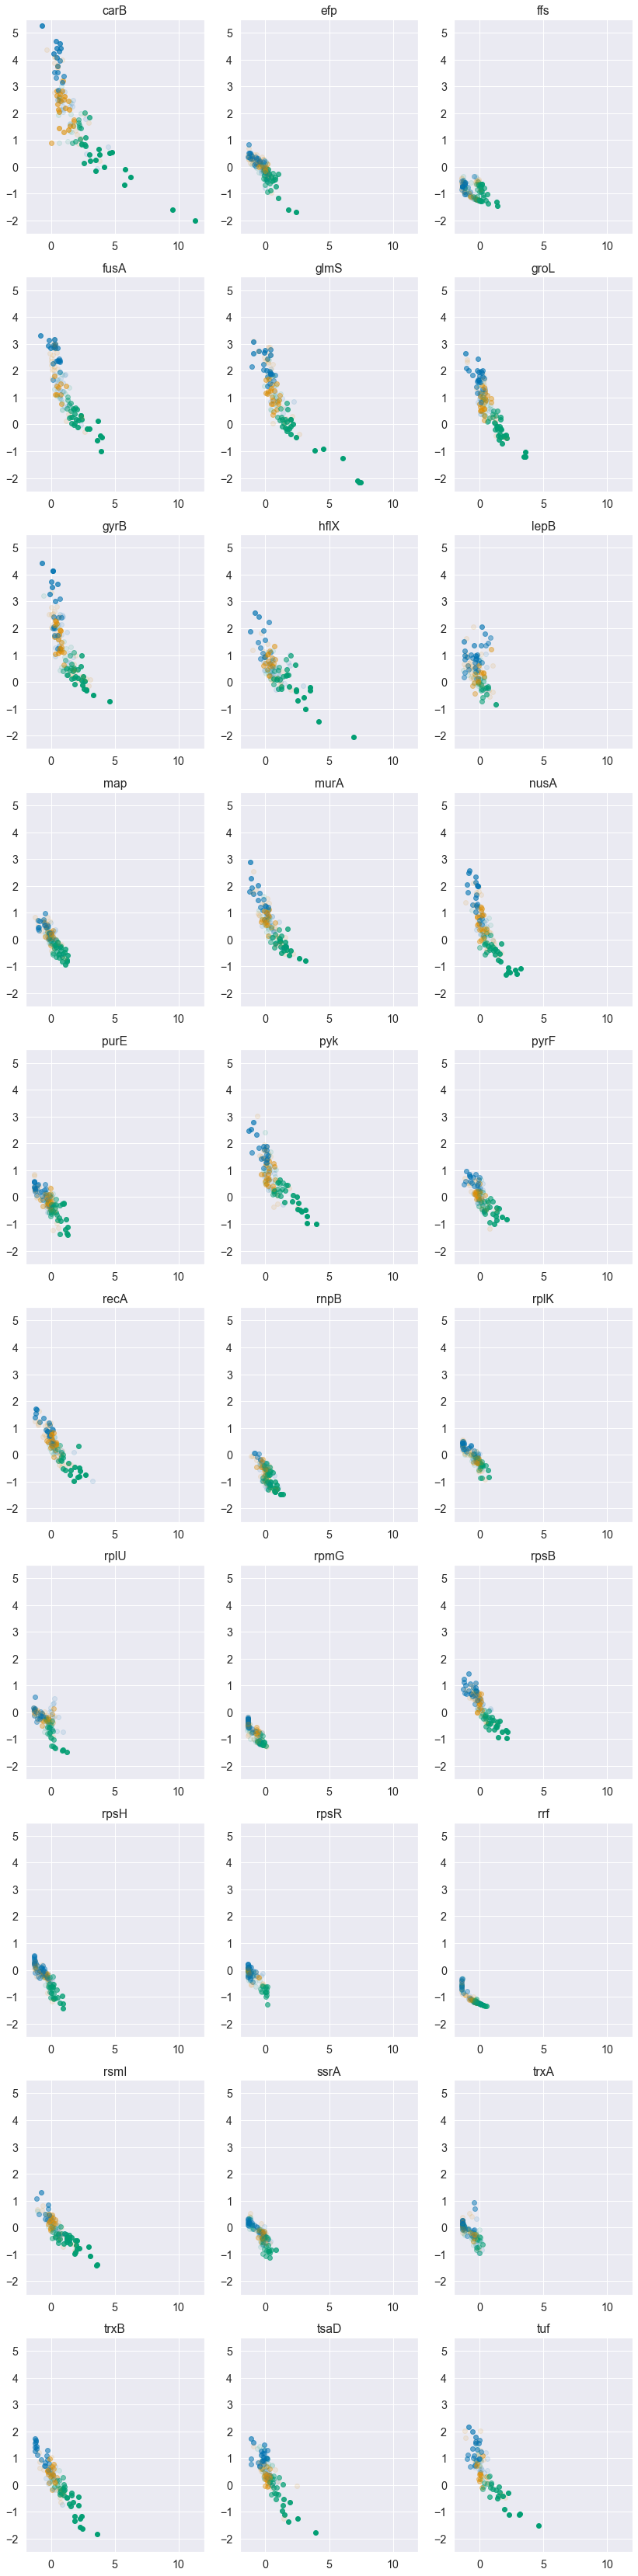

In [37]:
plot_breakdown_per_gene(dataset_df, encoding, np.array(labels), np.array(predictions), best_accuracy)

In [38]:
def accuracy_per_gene_per_class(dataset_df, predictions, labels, classes):
    f, ax = plt.subplots(1, 1, figsize=(12, 12))
    palette = sns.color_palette()
    
    genes = np.array(sorted(dataset_df['gene_name'].unique().tolist()))
    
    results = []
    for i, gene in enumerate(genes):
        res = []
        for j, cls in enumerate(classes):
            df = dataset_df[
                (dataset_df['gene_name'] == gene) &
                (dataset_df['temperature_range'] == cls)
            ]
            indices = df.index

            predictions_gene = predictions[indices]
            labels_gene = labels[indices]
            
            n_ok = len([k for k in range(len(predictions_gene)) if predictions_gene[k] == labels_gene[k]])
            
            res.append(n_ok / len(predictions_gene))
        
        results.append(res)
    
    sorted_idx = list(reversed(np.argsort([np.sum(r) for r in results]).tolist()))
    
    cm = pd.DataFrame(
        np.array(results)[sorted_idx], 
        index=[f'{g}' for i, g in enumerate(genes[sorted_idx])],
        columns=[f'{c.title()}' for i, c in enumerate(classes)],
    )
    sns.heatmap(cm, cmap="Greys", annot=True, fmt='.0%', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_title('Accuracy per gene')

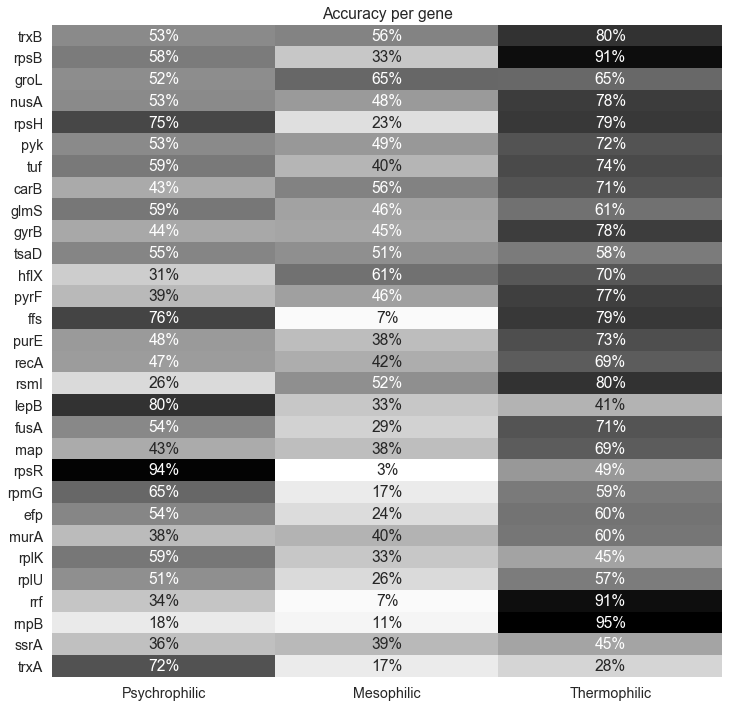

In [39]:
accuracy_per_gene_per_class(dataset_df, np.array(predictions), np.array(labels), classes)

In [40]:
def accuracy_per_temperature_per_class(dataset_df, predictions, labels, classes):
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    palette = sns.color_palette()
    
    bucket_size = 5
    bucket_starts = list(range(2, 76, bucket_size))
    temp_buckets = [f'{s}-{s + (bucket_size - 1)} °C' for s in bucket_starts]
    
    results = []
    for i, bucket_start in enumerate(bucket_starts):
        res = []
        for j, cls in enumerate(classes):
            df = dataset_df[
                (dataset_df['temperature'] >= bucket_start) &
                (dataset_df['temperature'] < bucket_start + bucket_size) &
                (dataset_df['temperature_range'] == cls)
            ]
            indices = df.index

            predictions_gene = predictions[indices]
            labels_gene = labels[indices]
            
            n_ok = len([k for k in range(len(predictions_gene)) if predictions_gene[k] == labels_gene[k]])
            
            if len(predictions_gene) > 0:
                res.append(n_ok / len(predictions_gene))
            else:
                res.append(np.nan)
        
        results.append(res)
    
    cm = pd.DataFrame(
        np.array(results), 
        index=[f'{g}' for i, g in enumerate(temp_buckets)],
        columns=[f'{c.title()}' for i, c in enumerate(classes)],
    )
    sns.heatmap(cm, cmap="Greys", annot=True, fmt='.0%', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_facecolor('#ffffff')
    ax.set_title('Accuracy per temperature band')

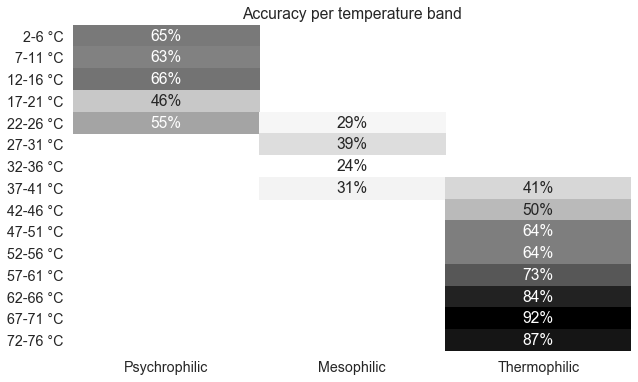

In [41]:
accuracy_per_temperature_per_class(dataset_df, np.array(predictions), np.array(labels), classes)